# CIFAR10 Classification: TensorFlow + Ray Tune Edition

In this notebook, we turn to hyperparameter tuning using Ray Tune.  Our objective is to find better hyperparams and network architecture. Although we will not spend too much time on network architecture, you probably will get enough information to try on your own.

**Q: Why would I want to use Ray Tune?**

A: If you are already using other Ray products, you know it already. You can easily scale your workload from a single machine to a cluster with ease. You can continue to use your favorite HPO libraries with ray tune, but now you can scale them too.

Author: Katnoria | Created: 03-Oct-2020

# 1. Imports & Setup

In [8]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

# tuner
import ray
from ray import tune
from ray.tune.integration.keras import TuneReporterCallback
from ray.tune.schedulers import ASHAScheduler

In [9]:
def version_info(cls):
    print(f"{cls.__name__}: {cls.__version__}")

In [10]:
print("Version Used in this Notebook:")
version_info(tf)
version_info(tfds)
version_info(ray)

Version Used in this Notebook:
tensorflow: 2.3.0
tensorflow_datasets: 3.2.1
ray: 0.8.7


In [11]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


# 2. Dataset

Tensorflow Datasets already provides this dataset in a format that we can use out of the box.

In [13]:
# Load the dataset
(ds_train, ds_test), metadata = tfds.load(
    'cifar10', split=['train', 'test'], shuffle_files=True, 
    with_info=True, as_supervised=True
)

In [14]:
len(ds_train), len(ds_test), metadata.features['label'].num_classes

(50000, 10000, 10)

Use the built in function to visualise the dataset 

In [15]:
# Review metadata
# See https://www.tensorflow.org/datasets/overview
metadata.features

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [16]:
NUM_CLASSES = metadata.features["label"].num_classes

num_train_examples = len(ds_train)
num_test_examples = len(ds_test)
print(f"Training dataset size: {num_train_examples}")
print(f"Test dataset size: {num_test_examples}")

Training dataset size: 50000
Test dataset size: 10000


## 2.1 Plot Images

Next, we plot some images from the training data

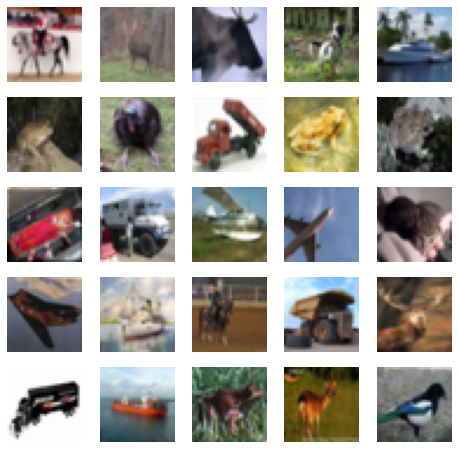

In [17]:
examples = ds_train.take(64)

fig, axs = plt.subplots(5, 5, figsize=(8,8))

for record, ax in zip(examples, axs.flat):
    image, _ = record
    ax.imshow(image)
    ax.axis('off')
plt.show()

# 3. RAY Tune

In the previous notebooks, we manually tried different hyperparameters. Now, we are going to automate that process and use ray to find the best hyperparams. 

We need to define the following:

* objective to maximise
* hyperparam search space
* search algorithm to find best hyperparams


![](https://docs.ray.io/en/latest/_images/tune-workflow.png)

Source: https://docs.ray.io/en/latest/tune/key-concepts.html

# 4. Use Pretrained Models
Instead of training the full model, it is generally a good practice to use a pretrained network as a base model and add your layers on top. This allows us to reduce the training times and leverage on what base model has learned.

### 4.1 Define Model

We will create our model that will accept hyperparams from the trainer. We are going to determine the best dropout rate, hidden units and activation to use in order to improve the model accuracy

In [30]:
class CIFAR10Model(Model):
    def __init__(self, base_model, num_classes, use_gap=False, drop_rate=0.1, hidden_units=128, hidden_activation='relu'):
        super(CIFAR10Model, self).__init__()
        self.base_model = base_model
        self.base_model.trainable = False
        self.use_gap = use_gap
        self.dropout = Dropout(drop_rate)
        self.fc1 = Dense(hidden_units, activation=hidden_activation)
        self.fc2 = Dense(num_classes)
        
    def call(self, x):
        x = self.base_model(x)
        if self.use_gap:
            x = GlobalAveragePooling2D()(x)
        else:
            x = Flatten()(x)
        x = self.fc1(x)
        x = self.dropout(x)
        return self.fc2(x)        

### 4.2 Trainable

This is where you will setup the model initialisation and training. `tune.run` will run this class instance  with different hyperparams based on the config

In [31]:
# Reference: https://docs.ray.io/en/latest/tune/examples/tf_mnist_example.html
class CIFAR10Trainable(tune.Trainable):

    def load_data(self, batch_size):
        (ds_train, ds_test), metadata = tfds.load(
            'cifar10', split=['train', 'test'], shuffle_files=True, 
            with_info=True, as_supervised=True
        )        
        num_classes = metadata.features["label"].num_classes
        
        train_ds = ds_train \
            .cache() \
            .shuffle(num_train_examples).batch(batch_size, drop_remainder=True) \
            .prefetch(tf.data.experimental.AUTOTUNE)      
        
        test_ds = ds_test \
            .cache() \
            .batch(batch_size, drop_remainder=True) \
            .prefetch(tf.data.experimental.AUTOTUNE)         
        
        return train_ds, test_ds, num_classes
    
    def setup(self, config):
        import tensorflow as tf
        IMG_SIZE = 32
        BATCH_SIZE = 128
        # load data
        self.train_ds, self.test_ds, num_classes = self.load_data(BATCH_SIZE)
        # model
        base_model = tf.keras.applications.ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False)
        self.model = CIFAR10Model(
            base_model,
            num_classes,
            config.get("use_gap", False),
            config.get("drop_rate", 0.1),
            config.get("hidden_units", 128),
            config.get("activation", "relu")
        )
        # set loss & optimizer
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.optimizer = tf.keras.optimizers.Adam(config.get("lr", 1e-3))
        # set train and test metrics
        self.train_loss = tf.keras.metrics.Mean(name="train_loss")
        self.train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train_accuracy")
        self.test_loss = tf.keras.metrics.Mean(name="test_loss")
        self.test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test_accuracy")
        
        @tf.function
        def train_step(images, labels):
            with tf.GradientTape() as tape:
                predictions = self.model(images)
                loss = self.loss_object(labels, predictions)
            gradients = tape.gradient(loss, self.model.trainable_variables)
            self.optimizer.apply_gradients(
                zip(gradients, self.model.trainable_variables)
            )
            # record metric
            self.train_loss(loss)
            self.train_accuracy(labels, predictions)
        
        @tf.function
        def test_step(images, labels):
            predictions = self.model(images)
            test_loss = self.loss_object(labels, predictions)            
            # record metric
            self.test_loss(test_loss)
            self.test_accuracy(labels, predictions)
        
        self.tf_train_step = train_step
        self.tf_test_step = test_step
        
    def step(self):
        # reset state
        self.train_loss.reset_states()
        self.train_accuracy.reset_states()
        self.test_loss.reset_states()
        self.test_accuracy.reset_states()
        # train step
        for images, labels in self.train_ds:
            self.tf_train_step(images, labels)
        # test step
        for images, labels in self.test_ds:
            self.tf_test_step(images, labels)
            
        return {
            "epoch": self.iteration,
            "loss": self.train_loss.result().numpy(),
            "accuracy": self.train_accuracy.result().numpy()*100,
            "test_loss": self.test_loss.result().numpy(),
            "mean_accuracy": self.test_accuracy.result().numpy()*100,
        }        

### 4.3 Setup Config

Config lets us set the hyperparams we want to tune.

Refer [docs](https://docs.ray.io/en/master/tune/api_docs/search_space.html#tune-sample-docs) to find out the list of search space options available. 

In [32]:
config = {
    "hidden_units": tune.grid_search([32, 64, 128, 256]),
#     "drop_rate": tune.quniform(0.0,0.8, 0.2), # says no attribute?
    "use_gap": tune.choice([True, False]), # Use Global Average Pooling
    "drop_rate": tune.uniform(0, 1),
    "activation": tune.choice(['elu', 'relu', 'selu']),
    "lr": tune.loguniform(1e-4, 1e-1)
}

# Terminate less promising trials using early stopping
scheduler = ASHAScheduler(metric="mean_accuracy", mode="max")

## 5. Run Trials

We are now ready to run the trials. You can comment the first two lines. I am doing it in order to access the dashboard over the network. 

In [ ]:
# shutdown currently running instance
ray.shutdown()
# initialize with the new param
ray.init(dashboard_host="0.0.0.0")

start = time()
# run trials
analysis = tune.run(
    CIFAR10Trainable,
    config=config,
    num_samples=15, # runs 15 jobs with separate sample from the search space
    scheduler=scheduler,
    stop={"training_iteration": 50},
     resources_per_trial={"cpu": 6, "gpu": 1},
    ray_auto_init=False
)
stop = time()

In [ ]:
took = stop - start
print(f"Total time: {took//60 : .0f}m {took%60:.0f}s")

### 5.1 Tensorboard

By default, Ray tune records all trials
If you have tensorboard installed, you can see the trial progress as well as hparams there.
`tensorboard --logdir ~/ray_results --host 0.0.0.0`

![](https://s3.amazonaws.com/katnoria.com/nbs/ray-tune-cf10.png)

### 5.2 Dataframe

You could also use the pandas dataframe and review the hyperparam with in this notebook.

In [35]:
df = analysis.dataframe()
df

,epoch,loss,accuracy,test_loss,mean_accuracy,done,timesteps_total,episodes_total,training_iteration,experiment_id,...,timesteps_since_restore,iterations_since_restore,trial_id,experiment_tag,config/activation,config/drop_rate,config/hidden_units,config/lr,config/use_gap,logdir
0,15,1.762451,33.253205,1.919790,31.770834,True,NaN,NaN,16,c2005e6434704a648b2d3318410c04e5,...,0,16,02a36_00000,"0_activation=selu,drop_rate=0.25301,hidden_uni...",selu,0.253014,32,0.028265,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
1,49,1.763553,30.869392,1.902017,25.831330,True,NaN,NaN,50,bcad4ee67d894174bf5d8594bba39f14,...,0,50,02a36_00001,"1_activation=relu,drop_rate=0.014704,hidden_un...",relu,0.014704,64,0.032551,False,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
2,49,0.985154,67.924678,1.966870,54.707533,True,NaN,NaN,50,8321b377f9f54bdab594ee1012d368a8,...,0,50,02a36_00002,"2_activation=selu,drop_rate=0.90218,hidden_uni...",selu,0.902179,128,0.012099,False,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
3,0,10.002253,11.786859,2.710080,10.697115,True,NaN,NaN,1,0aac0cce13434dd6bba220e6567962dc,...,0,1,02a36_00003,"3_activation=elu,drop_rate=0.52172,hidden_unit...",elu,0.521723,256,0.069150,False,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
4,0,2.397749,17.760417,2.078812,19.090545,True,NaN,NaN,1,d80a278b78684e339e09d28c6af96717,...,0,1,02a36_00004,"4_activation=relu,drop_rate=0.75516,hidden_uni...",relu,0.755162,32,0.028632,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
5,49,0.117418,96.087742,3.840001,56.620592,True,NaN,NaN,50,3df596c254a04541b8e0bae6171a8d24,...,0,50,02a36_00005,"5_activation=relu,drop_rate=0.40979,hidden_uni...",relu,0.409787,64,0.000769,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
6,49,0.105909,98.431492,1.843762,59.575319,True,NaN,NaN,50,946483d0cae745b389ba06b96e220d4e,...,0,50,02a36_00006,"6_activation=relu,drop_rate=0.54297,hidden_uni...",relu,0.542968,128,0.000125,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
7,0,4.739345,10.386618,2.304333,10.126202,True,NaN,NaN,1,55a878e9c774404db7afe0bc1576a861,...,0,1,02a36_00007,"7_activation=relu,drop_rate=0.65214,hidden_uni...",relu,0.652140,256,0.052467,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
8,0,3.108819,10.280449,2.391099,10.006010,True,NaN,NaN,1,02ade6dd99854073862edae4bd95cb4b,...,0,1,02a36_00008,"8_activation=selu,drop_rate=0.93812,hidden_uni...",selu,0.938119,32,0.094454,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...
9,0,2.364227,32.143429,1.474280,45.352563,True,NaN,NaN,1,1e299faf372241f398357849c6a0a6e0,...,0,1,02a36_00009,"9_activation=relu,drop_rate=0.0041715,hidden_u...",relu,0.004172,64,0.020772,True,/home/ashish/ray_results/CIFAR10Trainable/CIFA...


In [36]:
# Best mean accuracy
df['mean_accuracy'].max()

61.70873641967773

In [37]:
# Row with the best mean accuracy
df[df['mean_accuracy'] == df['mean_accuracy'].max()]

,epoch,loss,accuracy,test_loss,mean_accuracy,done,timesteps_total,episodes_total,training_iteration,experiment_id,...,timesteps_since_restore,iterations_since_restore,trial_id,experiment_tag,config/activation,config/drop_rate,config/hidden_units,config/lr,config/use_gap,logdir
27,49,0.001244,100.0,2.998994,61.708736,True,NaN,NaN,50,1227db67ff1549849ea6ae75d6766381,...,0,50,02a36_00027,"27_activation=relu,drop_rate=0.33668,hidden_un...",relu,0.336684,256,0.000372,False,/home/ashish/ray_results/CIFAR10Trainable/CIFA...


In [38]:
# best train accuracy
df[df['accuracy'] == df['accuracy'].max()]

,epoch,loss,accuracy,test_loss,mean_accuracy,done,timesteps_total,episodes_total,training_iteration,experiment_id,...,timesteps_since_restore,iterations_since_restore,trial_id,experiment_tag,config/activation,config/drop_rate,config/hidden_units,config/lr,config/use_gap,logdir
27,49,0.001244,100.0,2.998994,61.708736,True,NaN,NaN,50,1227db67ff1549849ea6ae75d6766381,...,0,50,02a36_00027,"27_activation=relu,drop_rate=0.33668,hidden_un...",relu,0.336684,256,0.000372,False,/home/ashish/ray_results/CIFAR10Trainable/CIFA...


In [28]:
# save to file
df.to_csv("v1-analysis.csv")

And, that's it. 

You are now ready to take Ray Tune for a spin 🚀.